# Shakespeare Sonnets: Trajectory Tortuosity Analysis
## Complete Analysis Using Contextualized BERT Embeddings

This notebook performs a complete trajectory tortuosity analysis on Shakespeare's 154 sonnets using:
- **EEBO-BERT**: Fine-tuned on Early English Books Online (1595-1700) - historical semantics
- **Poetry-BERT**: Fine-tuned on 17.7M lines of poetry - poetry specialization

**Analysis workflow:**
1. Load BERT models and Shakespeare sonnets
2. Extract contextualized embeddings for each line
3. Calculate trajectory tortuosity metrics
4. Compare EEBO-BERT vs Poetry-BERT
5. Visualize patterns across the sonnet sequence

## 1. Setup and Imports

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
from pathlib import Path

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports complete")

✓ Imports complete


## 2. Load BERT Models

We'll load both EEBO-BERT and Poetry-BERT for comparison.

In [2]:
# Model paths
EEBO_BERT_PATH = "/Users/justin/Library/CloudStorage/GoogleDrive-stecj2700@gmail.com/My Drive/AI and Poetry/Databases/Historical Embeddings/EEBO_1595-1700/eebo_bert_finetuned"
POETRY_BERT_PATH = "/Users/justin/Library/CloudStorage/GoogleDrive-stecj2700@gmail.com/My Drive/poetry_bert_trained"

# Determine device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}\n")

# Load EEBO-BERT
print("Loading EEBO-BERT (historical semantics 1595-1700)...")
tokenizer_eebo = BertTokenizer.from_pretrained(EEBO_BERT_PATH)
model_eebo = BertModel.from_pretrained(EEBO_BERT_PATH)
model_eebo.eval()
model_eebo.to(device)
print(f"✓ EEBO-BERT loaded: {model_eebo.num_parameters():,} parameters\n")

# Load Poetry-BERT
print("Loading Poetry-BERT (trained on 17.7M poetry lines)...")
tokenizer_poetry = BertTokenizer.from_pretrained(POETRY_BERT_PATH)
model_poetry = BertModel.from_pretrained(POETRY_BERT_PATH)
model_poetry.eval()
model_poetry.to(device)
print(f"✓ Poetry-BERT loaded: {model_poetry.num_parameters():,} parameters")

Some weights of BertModel were not initialized from the model checkpoint at /Users/justin/Library/CloudStorage/GoogleDrive-stecj2700@gmail.com/My Drive/AI and Poetry/Databases/Historical Embeddings/EEBO_1595-1700/eebo_bert_finetuned and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: mps

Loading EEBO-BERT (historical semantics 1595-1700)...


Some weights of BertModel were not initialized from the model checkpoint at /Users/justin/Library/CloudStorage/GoogleDrive-stecj2700@gmail.com/My Drive/poetry_bert_trained and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ EEBO-BERT loaded: 109,482,240 parameters

Loading Poetry-BERT (trained on 17.7M poetry lines)...
✓ Poetry-BERT loaded: 109,482,240 parameters


## 3. Load Shakespeare Sonnets

Load all 154 sonnets from the parsed JSONL file.

In [3]:
sonnets_path = Path('../corpus_samples/shakespeare_sonnets_parsed.jsonl')

sonnets = []
with open(sonnets_path, 'r') as f:
    for line in f:
        sonnets.append(json.loads(line))

print(f"✓ Loaded {len(sonnets)} sonnets")
print(f"\nExample - Sonnet 1:")
print(f"  Lines: {sonnets[0]['line_count']}")
print(f"  First line: {sonnets[0]['lines'][0]}")
print(f"  Last line: {sonnets[0]['lines'][-1]}")

✓ Loaded 154 sonnets

Example - Sonnet 1:
  Lines: 14
  First line: From fairest creatures we desire increase,
  Last line: To eat the world’s due, by the grave and thee.


## 4. Define Analysis Functions

### 4.1 Get Contextualized Embeddings

Extract contextualized embeddings from BERT's last hidden layer.

In [4]:
def get_line_embedding(text, model, tokenizer, device):
    """
    Get contextualized embedding for a line of text.
    
    Uses the mean of the last hidden layer (excluding [CLS] and [SEP] tokens)
    to create a single embedding vector representing the line.
    
    Args:
        text: Line of poetry
        model: BERT model
        tokenizer: BERT tokenizer
        device: torch device (cpu/mps/cuda)
    
    Returns:
        numpy array of shape (768,) - the line embedding
    """
    # Tokenize
    tokens = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    tokens = {k: v.to(device) for k, v in tokens.items()}
    
    # Get embeddings
    with torch.no_grad():
        outputs = model(**tokens)
    
    # Mean of last hidden layer (excluding [CLS] and [SEP])
    embeddings = outputs.last_hidden_state[0, 1:-1, :].mean(dim=0)
    
    return embeddings.cpu().numpy()

print("✓ get_line_embedding() defined")

✓ get_line_embedding() defined


### 4.2 Calculate Trajectory Tortuosity

Tortuosity measures how much a trajectory deviates from a straight line.

**Formula:** `tortuosity = Σ(angles) / euclidean_distance`

Where:
- `Σ(angles)` = cumulative angular deviation between consecutive embedding vectors
- `euclidean_distance` = straight-line distance from start to end

Higher tortuosity = more semantic complexity/density

In [5]:
def calculate_tortuosity(embeddings):
    """
    Calculate trajectory tortuosity from a sequence of embeddings.
    
    Args:
        embeddings: List of numpy arrays, each representing a line embedding
    
    Returns:
        float: tortuosity value (higher = more complex trajectory)
    """
    if len(embeddings) < 2:
        return 0.0
    
    # Calculate cumulative angular deviation
    total_angle = 0.0
    
    for i in range(len(embeddings) - 2):
        # Vectors between consecutive embeddings
        v1 = embeddings[i+1] - embeddings[i]
        v2 = embeddings[i+2] - embeddings[i+1]
        
        # Normalize vectors
        v1_norm = v1 / (np.linalg.norm(v1) + 1e-8)
        v2_norm = v2 / (np.linalg.norm(v2) + 1e-8)
        
        # Calculate angle between vectors
        cos_angle = np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0)
        angle = np.arccos(cos_angle)
        total_angle += angle
    
    # Euclidean distance from start to end
    euclidean = np.linalg.norm(embeddings[-1] - embeddings[0])
    
    if euclidean < 1e-8:
        return 0.0
    
    return total_angle / euclidean

print("✓ calculate_tortuosity() defined")

✓ calculate_tortuosity() defined


### 4.3 Analyze a Single Sonnet

Extract embeddings and calculate multiple tortuosity metrics:
- **Overall tortuosity**: Across all 14 lines
- **Mean line tortuosity**: Average complexity per line
- **Max line tortuosity**: Highest single-line complexity
- **Couplet tortuosity**: Complexity of final 2 lines

In [6]:
def analyze_sonnet(sonnet, model, tokenizer, device):
    """
    Analyze a single sonnet for trajectory tortuosity.
    
    Args:
        sonnet: Dictionary with 'sonnet_number' and 'lines'
        model: BERT model
        tokenizer: BERT tokenizer
        device: torch device
    
    Returns:
        Dictionary with tortuosity metrics
    """
    # Get embeddings for each line
    line_embeddings = []
    for line in sonnet['lines']:
        if line.strip():  # Skip empty lines
            emb = get_line_embedding(line, model, tokenizer, device)
            line_embeddings.append(emb)
    
    if len(line_embeddings) < 2:
        return None
    
    # Convert to numpy array
    line_embeddings = np.array(line_embeddings)
    
    # Overall tortuosity (across all lines)
    overall_tort = calculate_tortuosity(line_embeddings)
    
    # Per-line tortuosity (distance between consecutive lines)
    line_torts = []
    for i in range(len(line_embeddings) - 1):
        dist = np.linalg.norm(line_embeddings[i+1] - line_embeddings[i])
        line_torts.append(dist)
    
    mean_line_tort = np.mean(line_torts) if line_torts else 0.0
    max_line_tort = np.max(line_torts) if line_torts else 0.0
    
    # Couplet tortuosity (last 2 lines)
    if len(line_embeddings) >= 2:
        couplet_embeds = line_embeddings[-2:]
        couplet_tort = np.linalg.norm(couplet_embeds[1] - couplet_embeds[0])
    else:
        couplet_tort = 0.0
    
    return {
        'sonnet': sonnet['sonnet_number'],
        'overall_tortuosity': overall_tort,
        'mean_line_tortuosity': mean_line_tort,
        'max_line_tortuosity': max_line_tort,
        'couplet_tortuosity': couplet_tort,
        'num_lines': len(line_embeddings)
    }

print("✓ analyze_sonnet() defined")

✓ analyze_sonnet() defined


## 5. Run Analysis on All Sonnets

### 5.1 EEBO-BERT Analysis

In [7]:
print("Analyzing all 154 sonnets with EEBO-BERT...\n")

results_eebo = []
for sonnet in tqdm(sonnets, desc="EEBO-BERT"):
    result = analyze_sonnet(sonnet, model_eebo, tokenizer_eebo, device)
    if result:
        results_eebo.append(result)

df_eebo = pd.DataFrame(results_eebo)

print(f"\n✓ Analyzed {len(df_eebo)} sonnets with EEBO-BERT")
print(f"  Mean tortuosity: {df_eebo['overall_tortuosity'].mean():.2f}")
print(f"  SD: {df_eebo['overall_tortuosity'].std():.2f}")

# Save results
output_path = Path('../results/shakespeare_sonnets_eebo_bert_contextual.csv')
output_path.parent.mkdir(exist_ok=True)
df_eebo.to_csv(output_path, index=False)
print(f"\n✓ Saved to {output_path}")

Analyzing all 154 sonnets with EEBO-BERT...



EEBO-BERT: 100%|██████████| 154/154 [00:46<00:00,  3.32it/s]


✓ Analyzed 154 sonnets with EEBO-BERT
  Mean tortuosity: 3.45
  SD: 0.36

✓ Saved to ../results/shakespeare_sonnets_eebo_bert_contextual.csv


### 5.2 Poetry-BERT Analysis

In [8]:
print("Analyzing all 154 sonnets with Poetry-BERT...\n")

results_poetry = []
for sonnet in tqdm(sonnets, desc="Poetry-BERT"):
    result = analyze_sonnet(sonnet, model_poetry, tokenizer_poetry, device)
    if result:
        results_poetry.append(result)

df_poetry = pd.DataFrame(results_poetry)

print(f"\n✓ Analyzed {len(df_poetry)} sonnets with Poetry-BERT")
print(f"  Mean tortuosity: {df_poetry['overall_tortuosity'].mean():.2f}")
print(f"  SD: {df_poetry['overall_tortuosity'].std():.2f}")

# Save results
output_path = Path('../results/shakespeare_sonnets_poetry_bert_contextual.csv')
df_poetry.to_csv(output_path, index=False)
print(f"\n✓ Saved to {output_path}")

Analyzing all 154 sonnets with Poetry-BERT...



Poetry-BERT: 100%|██████████| 154/154 [00:53<00:00,  2.86it/s]


✓ Analyzed 154 sonnets with Poetry-BERT
  Mean tortuosity: 3.59
  SD: 0.35

✓ Saved to ../results/shakespeare_sonnets_poetry_bert_contextual.csv


## 6. Compare EEBO-BERT vs Poetry-BERT

### 6.1 Statistical Comparison

In [9]:
# Merge results
df_comparison = df_eebo.merge(
    df_poetry[['sonnet', 'overall_tortuosity', 'mean_line_tortuosity', 'couplet_tortuosity']], 
    on='sonnet', 
    suffixes=('_eebo', '_poetry')
)

print("="*70)
print("EEBO-BERT vs POETRY-BERT COMPARISON")
print("="*70)

print(f"\nOverall Tortuosity:")
print(f"  EEBO-BERT:   Mean={df_eebo['overall_tortuosity'].mean():.2f}, SD={df_eebo['overall_tortuosity'].std():.2f}")
print(f"  Poetry-BERT: Mean={df_poetry['overall_tortuosity'].mean():.2f}, SD={df_poetry['overall_tortuosity'].std():.2f}")

diff_mean = df_poetry['overall_tortuosity'].mean() - df_eebo['overall_tortuosity'].mean()
diff_sd = df_poetry['overall_tortuosity'].std() - df_eebo['overall_tortuosity'].std()
print(f"  Difference:  Mean={diff_mean:+.2f}, SD={diff_sd:+.2f}")

# Correlation
corr = df_comparison['overall_tortuosity_eebo'].corr(df_comparison['overall_tortuosity_poetry'])
print(f"\nCorrelation: {corr:.3f}")

# Top differences
df_comparison['abs_diff'] = abs(df_comparison['overall_tortuosity_eebo'] - df_comparison['overall_tortuosity_poetry'])
top_diff = df_comparison.nlargest(10, 'abs_diff')[['sonnet', 'overall_tortuosity_eebo', 'overall_tortuosity_poetry', 'abs_diff']]

print(f"\nTop 10 Sonnets with Biggest Difference:")
print(top_diff.to_string(index=False))

# Save comparison
df_comparison.to_csv('../results/eebo_vs_poetry_bert_contextual_comparison.csv', index=False)
print(f"\n✓ Saved comparison to results/eebo_vs_poetry_bert_contextual_comparison.csv")

EEBO-BERT vs POETRY-BERT COMPARISON

Overall Tortuosity:
  EEBO-BERT:   Mean=3.45, SD=0.36
  Poetry-BERT: Mean=3.59, SD=0.35
  Difference:  Mean=+0.14, SD=-0.01

Correlation: 0.630

Top 10 Sonnets with Biggest Difference:
 sonnet  overall_tortuosity_eebo  overall_tortuosity_poetry  abs_diff
     46                 3.470242                   4.572891  1.102648
     75                 3.089237                   4.128175  1.038938
    151                 2.982544                   3.948661  0.966117
    144                 3.015704                   3.908688  0.892985
      4                 2.860223                   3.650414  0.790191
     42                 3.453334                   4.152614  0.699280
     20                 2.933004                   3.597249  0.664246
     47                 3.526240                   4.176550  0.650310
    117                 2.659410                   3.293130  0.633720
    127                 3.312827                   3.930504  0.617677

✓ Saved

### 6.2 Visualization: Distribution Comparison

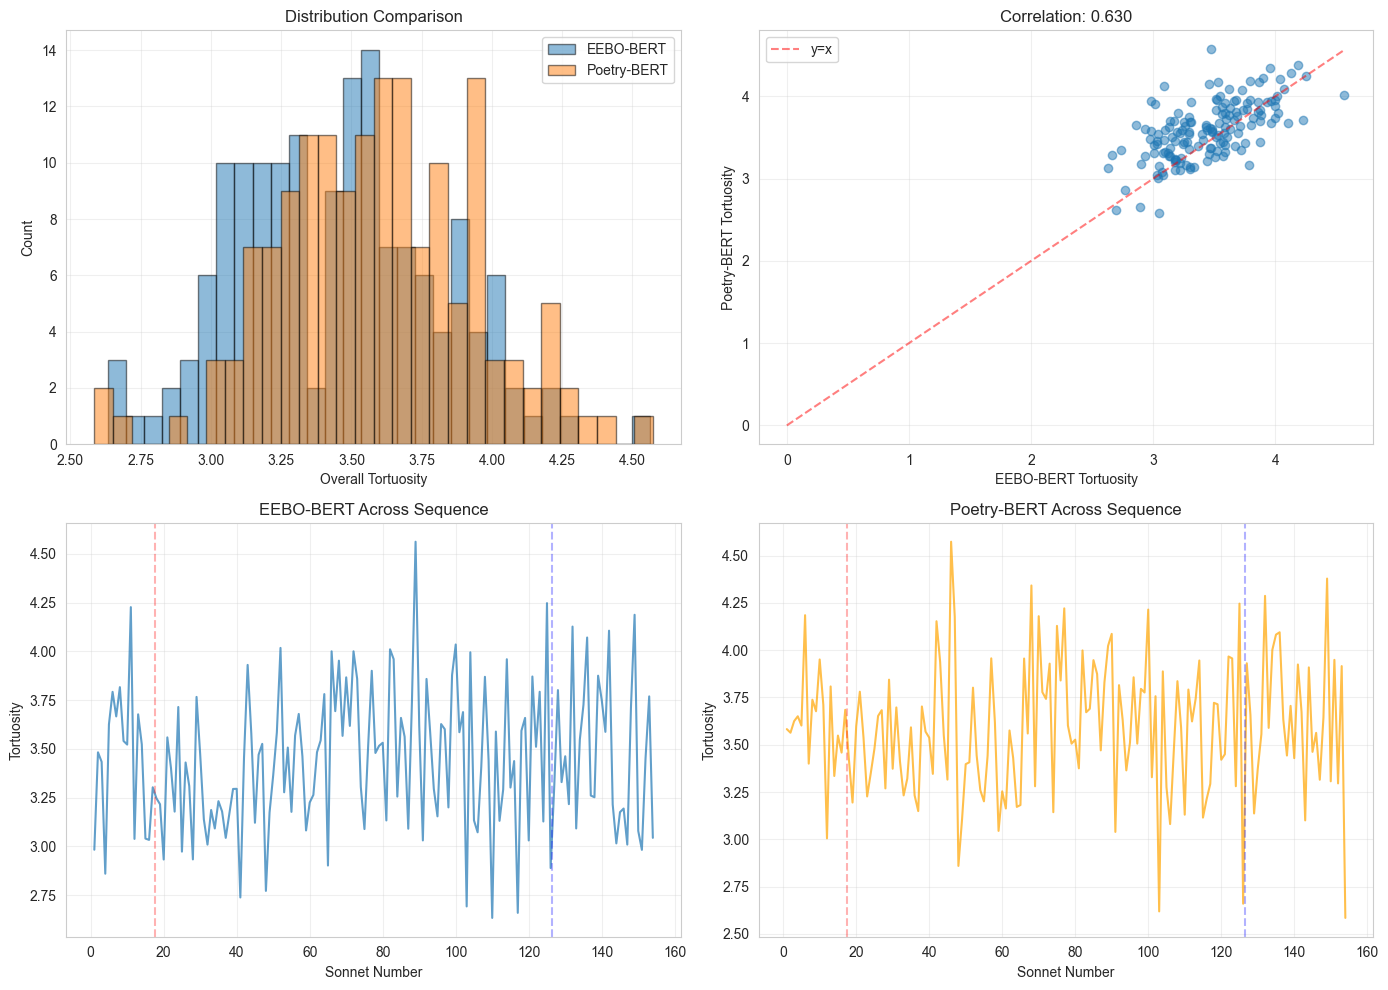

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distributions
axes[0, 0].hist(df_eebo['overall_tortuosity'], bins=30, alpha=0.5, label='EEBO-BERT', edgecolor='black')
axes[0, 0].hist(df_poetry['overall_tortuosity'], bins=30, alpha=0.5, label='Poetry-BERT', edgecolor='black')
axes[0, 0].set_xlabel('Overall Tortuosity')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution Comparison')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Scatter plot
axes[0, 1].scatter(df_comparison['overall_tortuosity_eebo'], df_comparison['overall_tortuosity_poetry'], alpha=0.5)
max_val = max(df_comparison['overall_tortuosity_eebo'].max(), df_comparison['overall_tortuosity_poetry'].max())
axes[0, 1].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='y=x')
axes[0, 1].set_xlabel('EEBO-BERT Tortuosity')
axes[0, 1].set_ylabel('Poetry-BERT Tortuosity')
axes[0, 1].set_title(f'Correlation: {corr:.3f}')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Across sequence (EEBO)
axes[1, 0].plot(df_eebo['sonnet'], df_eebo['overall_tortuosity'], alpha=0.7, label='EEBO-BERT')
axes[1, 0].axvline(17.5, color='red', linestyle='--', alpha=0.3)
axes[1, 0].axvline(126.5, color='blue', linestyle='--', alpha=0.3)
axes[1, 0].set_xlabel('Sonnet Number')
axes[1, 0].set_ylabel('Tortuosity')
axes[1, 0].set_title('EEBO-BERT Across Sequence')
axes[1, 0].grid(alpha=0.3)

# 4. Across sequence (Poetry)
axes[1, 1].plot(df_poetry['sonnet'], df_poetry['overall_tortuosity'], alpha=0.7, color='orange', label='Poetry-BERT')
axes[1, 1].axvline(17.5, color='red', linestyle='--', alpha=0.3)
axes[1, 1].axvline(126.5, color='blue', linestyle='--', alpha=0.3)
axes[1, 1].set_xlabel('Sonnet Number')
axes[1, 1].set_ylabel('Tortuosity')
axes[1, 1].set_title('Poetry-BERT Across Sequence')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6.3 Couplet Analysis Comparison

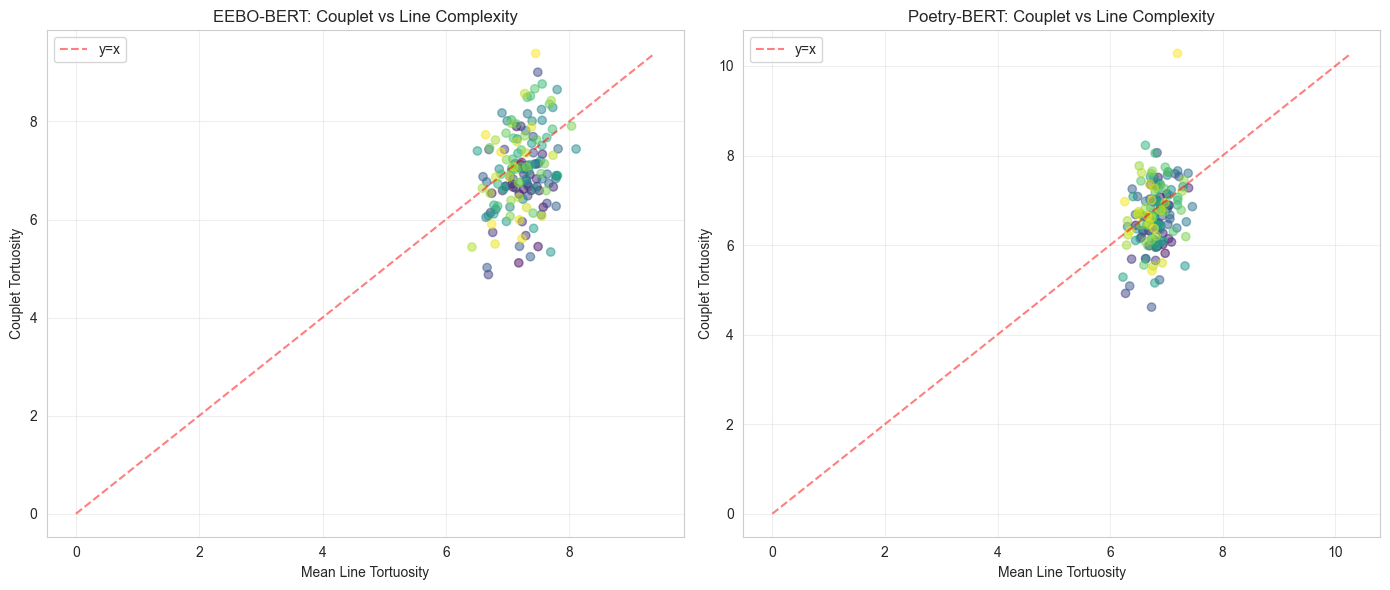


Couplet Statistics:
EEBO-BERT:   53 sonnets (34.4%) have couplets more complex than average line
Poetry-BERT: 58 sonnets (37.7%) have couplets more complex than average line


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# EEBO-BERT couplet analysis
axes[0].scatter(df_eebo['mean_line_tortuosity'], df_eebo['couplet_tortuosity'], alpha=0.5, c=df_eebo['sonnet'], cmap='viridis')
max_val = max(df_eebo['mean_line_tortuosity'].max(), df_eebo['couplet_tortuosity'].max())
axes[0].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='y=x')
axes[0].set_xlabel('Mean Line Tortuosity')
axes[0].set_ylabel('Couplet Tortuosity')
axes[0].set_title('EEBO-BERT: Couplet vs Line Complexity')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Poetry-BERT couplet analysis
axes[1].scatter(df_poetry['mean_line_tortuosity'], df_poetry['couplet_tortuosity'], alpha=0.5, c=df_poetry['sonnet'], cmap='viridis')
max_val = max(df_poetry['mean_line_tortuosity'].max(), df_poetry['couplet_tortuosity'].max())
axes[1].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='y=x')
axes[1].set_xlabel('Mean Line Tortuosity')
axes[1].set_ylabel('Couplet Tortuosity')
axes[1].set_title('Poetry-BERT: Couplet vs Line Complexity')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("\nCouplet Statistics:")
print("="*70)
eebo_high_couplet = (df_eebo['couplet_tortuosity'] > df_eebo['mean_line_tortuosity']).sum()
poetry_high_couplet = (df_poetry['couplet_tortuosity'] > df_poetry['mean_line_tortuosity']).sum()

print(f"EEBO-BERT:   {eebo_high_couplet} sonnets ({eebo_high_couplet/len(df_eebo)*100:.1f}%) have couplets more complex than average line")
print(f"Poetry-BERT: {poetry_high_couplet} sonnets ({poetry_high_couplet/len(df_poetry)*100:.1f}%) have couplets more complex than average line")

## 7. Detailed Analysis: Top Complex Sonnets

### 7.1 EEBO-BERT Top 10

In [12]:
top10_eebo = df_eebo.nlargest(10, 'overall_tortuosity')

print("TOP 10 MOST COMPLEX SONNETS (EEBO-BERT)")
print("="*70)
for idx, row in top10_eebo.iterrows():
    sonnet_num = int(row['sonnet'])
    sonnet = sonnets[sonnet_num - 1]
    print(f"\nSonnet {sonnet_num}: Tortuosity = {row['overall_tortuosity']:.2f}")
    print(f"  First line: {sonnet['lines'][0]}")
    print(f"  Couplet:")
    print(f"    {sonnet['lines'][-2]}")
    print(f"    {sonnet['lines'][-1]}")

TOP 10 MOST COMPLEX SONNETS (EEBO-BERT)

Sonnet 89: Tortuosity = 4.56
  First line: Say that thou didst forsake me for some fault,
  Couplet:
    For thee, against my self I’ll vow debate,
    For I must ne’er love him whom thou dost hate.

Sonnet 125: Tortuosity = 4.25
  First line: Were’t aught to me I bore the canopy,
  Couplet:
    Hence, thou suborned informer! a true soul
    When most impeach’d, stands least in thy control.

Sonnet 11: Tortuosity = 4.23
  First line: As fast as thou shalt wane, so fast thou grow’st,
  Couplet:
    She carv’d thee for her seal, and meant thereby,
    Thou shouldst print more, not let that copy die.

Sonnet 149: Tortuosity = 4.19
  First line: Canst thou, O cruel! say I love thee not,
  Couplet:
    But, love, hate on, for now I know thy mind;
    Those that can see thou lov’st, and I am blind.

Sonnet 132: Tortuosity = 4.13
  First line: Thine eyes I love, and they, as pitying me,
  Couplet:
    Then will I swear beauty herself is black,
    And 

### 7.2 Poetry-BERT Top 10

In [13]:
top10_poetry = df_poetry.nlargest(10, 'overall_tortuosity')

print("TOP 10 MOST COMPLEX SONNETS (POETRY-BERT)")
print("="*70)
for idx, row in top10_poetry.iterrows():
    sonnet_num = int(row['sonnet'])
    sonnet = sonnets[sonnet_num - 1]
    print(f"\nSonnet {sonnet_num}: Tortuosity = {row['overall_tortuosity']:.2f}")
    print(f"  First line: {sonnet['lines'][0]}")
    print(f"  Couplet:")
    print(f"    {sonnet['lines'][-2]}")
    print(f"    {sonnet['lines'][-1]}")

TOP 10 MOST COMPLEX SONNETS (POETRY-BERT)

Sonnet 46: Tortuosity = 4.57
  First line: Mine eye and heart are at a mortal war,
  Couplet:
    As thus; mine eye’s due is thy outward part,
    And my heart’s right, thy inward love of heart.

Sonnet 149: Tortuosity = 4.38
  First line: Canst thou, O cruel! say I love thee not,
  Couplet:
    But, love, hate on, for now I know thy mind;
    Those that can see thou lov’st, and I am blind.

Sonnet 68: Tortuosity = 4.34
  First line: Thus is his cheek the map of days outworn,
  Couplet:
    And him as for a map doth Nature store,
    To show false Art what beauty was of yore.

Sonnet 132: Tortuosity = 4.29
  First line: Thine eyes I love, and they, as pitying me,
  Couplet:
    Then will I swear beauty herself is black,
    And all they foul that thy complexion lack.

Sonnet 125: Tortuosity = 4.25
  First line: Were’t aught to me I bore the canopy,
  Couplet:
    Hence, thou suborned informer! a true soul
    When most impeach’d, stands least 

## 8. Summary

This notebook demonstrates:
1. **Complete workflow** from loading BERT models to final analysis
2. **Contextualized embeddings** using BERT's last hidden layer
3. **Trajectory tortuosity** as a measure of semantic complexity
4. **Comparison** between historical (EEBO) and poetry-specialized BERT models
5. **Couplet analysis** showing whether final lines are more/less complex than the rest

All results are saved to `../results/` for further analysis.